<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/Klochkov_HWTask_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

Всего у вас 2 домашних задания:

### 1) Бинарная классификация на примере детекции фрода на кредитных картах (6 баллов)
(в этом файле)

### 2) Небинарная классификация на вашем датасете (6 баллов)
(тоже в этом файле)

# 1 - Бинарная классификация на примере детекции фрода на кредитных картах (суммарно 6 баллов)
У вас есть информация о множесте транзакций. Вам нужно научиться предсказывать, какие из них мошеннические, а какие нет.

### (1 балл) Считайте данные
Сами считайте и предобработайте, если надо, данные из файла creditcard.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/drive/MyDrive/Colab_Notebooks/archive.zip' -d data


Archive:  /content/drive/MyDrive/Colab_Notebooks/archive.zip
replace data/creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### (2 балла) Обучите несколько моделей, посмотрите на метрики.
Как модели точно возьмите LogisticRegression, KNN и константу, можете придумать еще какие-нибудь.

Как метрики точно возьмите accuracy, precision, recall, f1, roc_auc. Постройте ROC-кривую.

In [ ]:
from sklearn.neighbors  import KNeighborsClassifier
from functools import reduce

Ниже функции для перерасчета времени в формат: дни, часы, минуты, секунды. В данном случае часы важнее, так как определённо должна быть периодичность определённая транзакций в дневное и ночное время.

Это надо как-то использовать!

In [ ]:
def time_represent(seconds, days = False):
  # get seconds and transform to (h, m, s)
  minutes_ = int(seconds//60)
  seconds_ = int(seconds % 60)
  hours_ = int(minutes_ // 60)
  minutes_ = int(minutes_ % 60) 

  if (days):
    days_ = int(hours_//24)
    hours_ = int(hours_ % 24)
    return days_, hours_, minutes_, seconds_
  else:
    return hours_, minutes_, seconds_

def get_days(seconds):
  return int(seconds // (60 * 60 * 24))


class Time():

  def __init__(self, seconds, days = False):
    time_list = time_represent(seconds, days = days)
    self._d, self._h, self._m, self._s = time_list
  
  def get_d(self):
    return self._d

  def get_h(self):
    return self._h

  def get_m(self):
    return self._m

  def get_s(self):
    return self._s
 

t = Time(time_last, days = True)
time_represent(time_last, days = True)

(1, 23, 59, 52)

In [ ]:
new_features = ['t_' + t for t in ['d', 'h', 'm', 's']]
new_features

['t_d', 't_h', 't_m', 't_s']

In [ ]:
df_copy = df.copy(deep = True)

In [ ]:
idx = 0
def get_d(s):
  t = Time(s, days = True)
  return t.get_d()


def get_h(s):
  t = Time(s, days = True)
  return t.get_h()

  
def get_m(s):
  t = Time(s, days = True)
  return t.get_m()


def get_s(s):
  t = Time(s, days = True)
  return t.get_s()


Добавляем новые фичи с временем: дни, часы, минуты, секунды с ммента первой транзакции.

In [ ]:
idx = 0
df[new_features[idx]] = df.Time.apply(lambda s: get_d(s))

idx = 1
df[new_features[idx]] = df.Time.apply(lambda s: get_h(s))

idx = 2
df[new_features[idx]] = df.Time.apply(lambda s: get_m(s))

idx = 3
df[new_features[idx]] = df.Time.apply(lambda s: get_s(s))

In [ ]:
# look at the Amount column
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,t_d,t_h,t_m,t_s
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0,0,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,0,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,0,2


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,t_d,t_h,t_m,t_s
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727,0.491635,14.046470,28.997044,29.507856
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,0.499931,5.835854,17.427849,17.282889
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,0.000000,10.000000,14.000000,15.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,15.000000,29.000000,30.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,1.000000,19.000000,44.000000,44.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.000000,23.000000,59.000000,59.000000


In [ ]:
df.groupby(by = ['Class'])['Class'].count().sum() == df.shape[0]

True

In [ ]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
t_d       0
t_h       0
t_m       0
t_s       0
dtype: int64

Видим огромный дисбаланс классов. Хмм, какие же стратегии использовать для построения модели с огромным диссбалансом? Ovesampling, Downsampling или просто в logisticregression передать параметр weighted = 'balanced'.

In [ ]:
# disbalance very very biiig (How to work with unbalanced classes, для нас очень важно различать мошеничество)
df.groupby(by = ['Class'])['Class'].count()*100./df.shape[0]

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64

Видим сильно смешенные данные Amount - (вероятно много выбросов). 

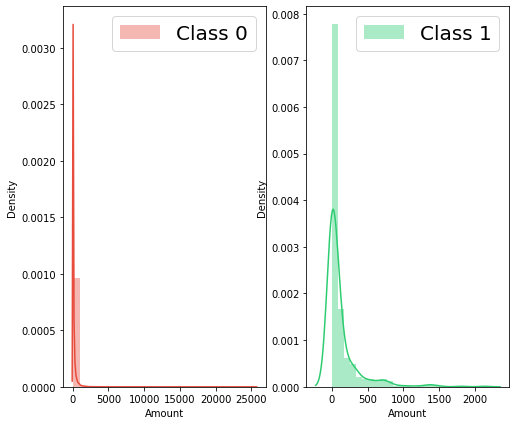

In [ ]:

Classes = [0, 1]
fig, ax = plt.subplots(1, 2, figsize = (8, 7))
plt.subplots_adjust()
colors = ['#e74c3c', '#2ecc71']

#for idx, cls in enumerate(Classes):
sns.distplot(df[df.Class == 0].Amount, label = 'Class ' + str(0), 
                hist = True, color = colors[0], ax = ax[0], bins = 25)

sns.distplot(df[df.Class == 1].Amount, label = 'Class ' + str(1), 
                hist = True, color = colors[1], ax = ax[1], bins = 25)

ax[0].legend(loc = 'upper right', prop = {'size': 20})
ax[1].legend(loc = 'upper right', prop = {'size': 20})

In [ ]:
import scipy.stats as stats


Будем опираться на главную метрику ROC_AUC. Но также будем смотреть на ROC_AUC.

In [ ]:

y_test, y_pred = np.random.randint(0, 2, size = 10),  np.random.randint(0, 2, size = 10)
# Расчёт матрицы ошибок
def confusion_matrix_my(y_pred, y):
  # we have 0-1 labels
  # TP FP
  # FN TN
  TP = ((y == y_pred) & (y == 0)).astype(int).sum()
  FP = ((y != y_pred) & (y == 1)).astype(int).sum()
  FN = ((y != y_pred) & (y == 0)).astype(int).sum()
  TN = ((y == y_pred) & (y == 1)).astype(int).sum()
  conf_m = np.array([[TP, FP], [FN, TN]])
  return pd.DataFrame(data = conf_m, columns = ['true 0', 'true 1'], index = ['a 0', 'a 1'])
  
confusion_matrix_my(y_pred, y_test)

,true 0,true 1
a 0,2,2
a 1,1,5


In [ ]:
# amount величина транзакции, давайте посмотрим какие стоимости имеют подобные транзакции?
df[df.Class == 1].Amount.describe()
df[df.Class == 1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
from sklearn.metrics import recall_score, precision_score

In [ ]:
non_known_cols = [col for col in df.columns if col[0] == 'V']
non_known_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28']

Построим величину стандартного отклонения неизвестных колонок. 
Среднее будет 0.

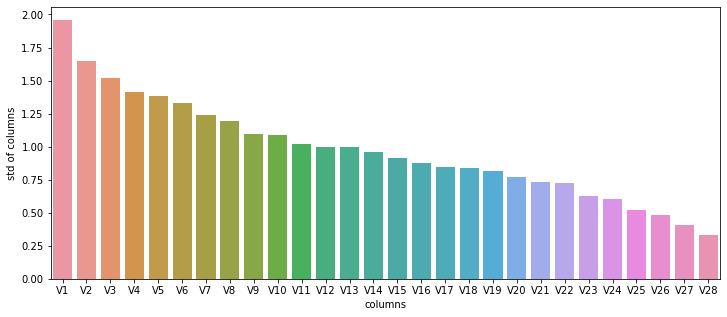

In [ ]:
mean_std_V = df_copy[non_known_cols].describe().loc[['mean', 'std'], :]
# У всех среднее 0, а вот стандартное отклонения будет не 1 у всех
fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(x = list(mean_std_V.columns), y = mean_std_V.loc['std', : ], 
            ax = ax)

ax.set_xlabel('columns')
ax.set_ylabel('std of columns');


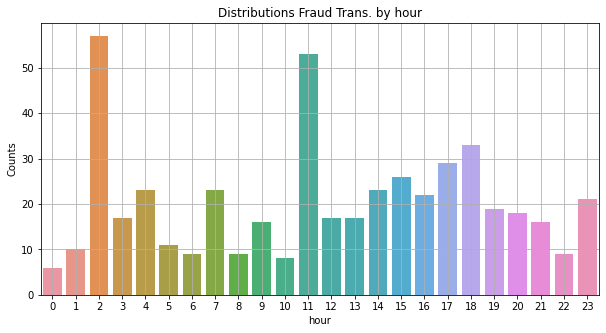

In [ ]:
# Попробуем понять, была ли упорядоченность по времени транзакций мошеннических?
# Можно просто взять и посмотреть по дням, выделить, возможно есть периодизация?
# Ниже периодизация ложных транзакций по часам
fig, ax = plt.subplots(figsize = (10, 5))
days = df[df.Class == 1].groupby(['t_d'])['t_d'].count()
hours = df[df.Class == 1].groupby(['t_h'])['t_h'].count()
sns.barplot(x = list(hours.index), y = hours.values, ax = ax)
ax.grid()
ax.set_title('Distributions Fraud Trans. by hour')
ax.set_xlabel('hour');
ax.set_ylabel('Counts');

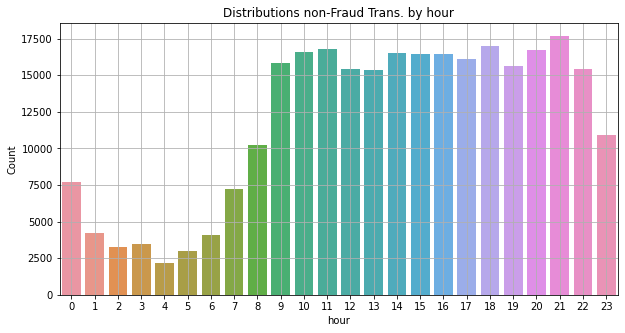

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
hours = df[df.Class == 0].groupby(['t_h'])['t_h'].count()
sns.barplot(x = list(hours.index), y = hours.values, ax = ax)
ax.grid()
ax.set_title('Distributions non-Fraud Trans. by hour')
ax.set_xlabel('hour');
ax.set_ylabel('Count');
# Ниже нормальные транзакции, видно, что есть серьезное отличие в виде нашей зависимости
# Есть перид (ночь), когда их очень мало

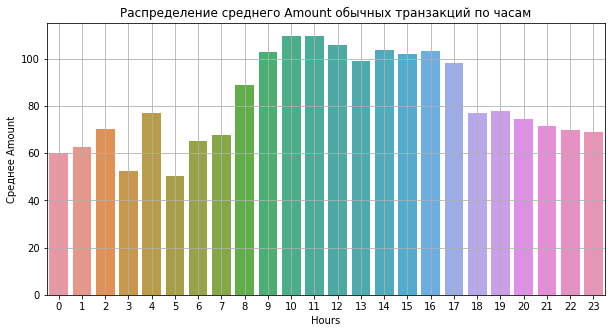

In [ ]:
# В качестве дополнительного исследования можно посмотреть, 
# как будут зависеть средняя стоимость транзакции в определенный час 
fig, ax = plt.subplots(figsize = (10, 5))
hours = df[df.Class == 0].groupby(['t_h'])['Amount'].mean()
sns.barplot(x = list(hours.index), y = hours.values, ax = ax)
ax.grid()
ax.set_title('Распределение среднего Amount обычных транзакций по часам')
ax.set_ylabel('Среднее Amount')
ax.set_xlabel('Hours');


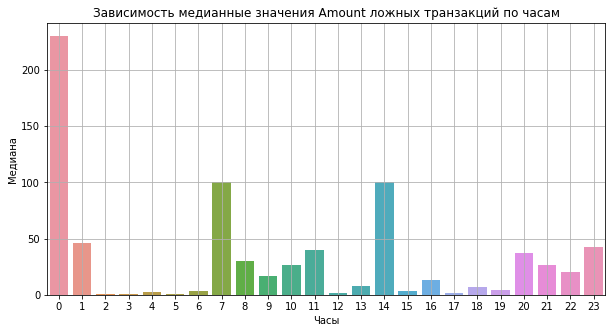

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

hours = df[df.Class == 1].groupby(['t_h'])['Amount'].median()
sns.barplot(x = list(hours.index), y = hours.values, ax = ax)
ax.grid()
ax.set_title('Зависимость медианные значения Amount ложных транзакций по часам')
ax.set_xlabel('Часы')
ax.set_ylabel('Медиана');



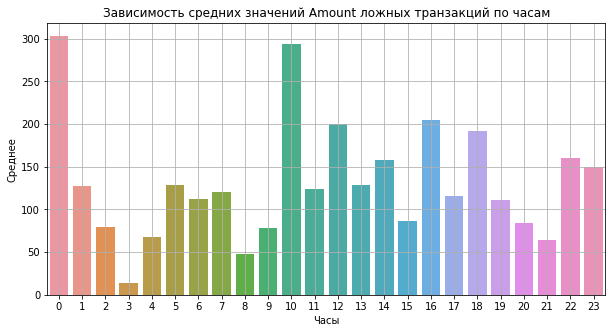

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
#days = df[df.Class == 0].groupby(['t_d'])['t_d'].count()
hours = df[df.Class == 1].groupby(['t_h'])['Amount'].mean()
sns.barplot(x = list(hours.index), y = hours.values, ax = ax)
ax.grid()

ax.set_title('Зависимость средних значений Amount ложных транзакций по часам')
ax.set_xlabel('Часы')
ax.set_ylabel('Среднее');

In [ ]:
number_of_zero_trans_f = (df[df.Class == 1].Amount == 0).sum()
number_of_zero_trans_n = (df[df.Class == 0].Amount == 0).sum()
print('ratio of zero amount fraud: {}\nratio of zero amount norm: {}'.format( 
        number_of_zero_trans_f * 100./df[df.Class == 1].shape[0], 
        number_of_zero_trans_n * 100./df[df.Class == 0].shape[0])
        )

# Доля транзакций с 0 будет в 10 раз меньше, чем у обычных транзакций, надо бы это учесть

ratio of zero amount fraud: 5.487804878048781
ratio of zero amount norm: 0.6323971651161564


In [ ]:
# Интеренсно, что стандартные отклонения у данных признаков упорядочены по убыванию, чтобы это могло значить?

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
X = df.drop(columns = ['Class', 't_m', 't_s', 't_d', 't_h'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2)
print((y_train == 1).sum()/(y == 1).sum(),(y_test == 1).sum()/(y == 1).sum())
lg = LogisticRegression()
lg.fit(X_train, y_train)

0.7967479674796748 0.2032520325203252


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lg.predict(X_test)
y_pred_proba = lg.predict_proba(X_test)


In [ ]:
indeces_sort = y_pred_proba[:, 1].argsort()[::-1]
y_test_ordered = y_test[indeces_sort]
m, n = (y_test_ordered == 1).sum(), (y_test_ordered == 0).sum()
fpr, tpr = [0], [0]
trex = 1./m
trey = 1./n 
for idx, y in enumerate(y_test_ordered):
  if(y == 0):
    fpr.append(fpr[-1] + 1)
    tpr.append(tpr[-1])
  else:
    tpr.append(tpr[-1] + 1)
    fpr.append(fpr[-1])




In [ ]:
def built_roc_auc(y_test, y_pred_proba):
  fpr_s, tpr_s, _  = roc_curve(y_test, y_pred_proba[:, 1])
  #plt.plot(fpr/n, tpr/m, c = 'r')
  plt.plot(fpr_s, tpr_s, c = 'b', label = 'logistic regression')
  plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c = 'g', linestyle = '--')
  plt.plot(np.linspace(0, 1, 100), [1] * 100, c = 'y', linestyle = '--')
  plt.plot([1] * 100,np.linspace(0, 1, 100) , c = 'y', linestyle = '--')
  plt.plot(np.linspace(0, 1, 100), [0] * 100 , c = 'y', linestyle = '--')
  plt.plot([0] * 100, np.linspace(0, 1,100), c = 'y', linestyle = '--')
  plt.legend()
  plt.show()
  return fpr_s, tpr_s

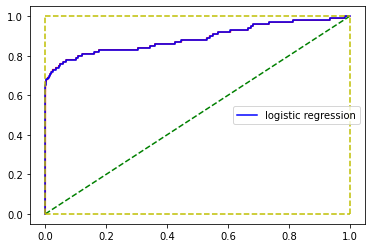

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_s, tpr_s, _  = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr/n, tpr/m, c = 'r')
plt.plot(fpr_s, tpr_s, c = 'b', label = 'logistic regression')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c = 'g', linestyle = '--')
plt.plot(np.linspace(0, 1, 100), [1] * 100, c = 'y', linestyle = '--')
plt.plot([1] * 100,np.linspace(0, 1, 100) , c = 'y', linestyle = '--')
plt.plot(np.linspace(0, 1, 100), [0] * 100 , c = 'y', linestyle = '--')
plt.plot([0] * 100, np.linspace(0, 1,100), c = 'y', linestyle = '--')
plt.legend()
plt.show()


In [ ]:
auc_score_default = auc(fpr/m, tpr/n)
print('auc with default LogRegr, without engeneering: {:.4f}'.format(auc_score_default))

auc with default LogRegr, without engeneering: 0.8882


In [ ]:
my_conf_m = confusion_matrix_my(y_pred, y_test)
my_conf_m

,true 0,true 1
a 0,56839,37
a 1,23,63


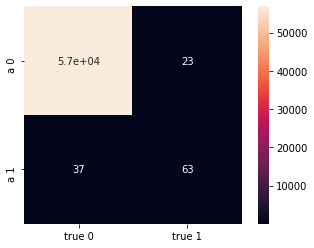

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), square = True,
            xticklabels = my_conf_m.columns, yticklabels = my_conf_m.index, 
            annot = True)

In [ ]:
# Надо сделать ошибку на мошенниках как можно меньше, так как нам важно уметь предсказывать её лучше

In [ ]:
def built_conf_matr(y_test, y_pred):
  matr = confusion_matrix_my(y_pred, y_test)
  sns.heatmap(confusion_matrix(y_test, y_pred), square = True,
            xticklabels = my_conf_m.T.columns, yticklabels = my_conf_m.T.index, 
            annot = True)
  plt.show()
  return matr



Просто дефолтно без каких либо модернизаций

In [ ]:
X = df.drop(columns = ['Class', 't_m', 't_s', 't_d', 't_h'])
y = df['Class']
cv = StratifiedKFold(5, shuffle = True)
n_scores = cross_val_score(lg, X, y, scoring = 'roc_auc', cv = cv)

In [ ]:
print('cross_val_score auc: {:.3f} +- {:.3f} '.format(n_scores.mean(),
                                                    n_scores.std()))

cross_val_score auc: 0.914 +- 0.024 


Если нормировать 

In [ ]:
cv = StratifiedKFold(5, shuffle = True)
n_scores = cross_val_score(lg, (X - X.mean(axis = 0))/X.std(axis = 0), y,
                           scoring = 'roc_auc', cv = cv)

In [ ]:
print('cross_val_score (standartizize) auc: {:.3f} +- {:.3f} '.format(n_scores.mean(),
                                                    n_scores.std()))

cross_val_score (standartizize) auc: 0.976 +- 0.010 


In [ ]:
def cross_val_score_my(model, X, y, cv = 5, scoring = 'roc_auc', text = '', return_scores = False):
  assert(X.shape[0] == y.shape[0])
  cv = StratifiedKFold(n_splits = cv, shuffle = True)
  n_scores = cross_val_score(model, X, y, cv = cv, scoring = scoring)

  print('cross_val_score {} auc: {:.3f} +- {:.3f} '.format(text, n_scores.mean(),
                                                    n_scores.std()))
  
  if(return_scores):
    return n_scores

    
  

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
lg_stand = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
tuned_parameters = {'logisticregression__C': [1.0, 2.0, 3.0]}
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight = 'balanced')
)
cv = StratifiedKFold(n_splits=5, shuffle = True)
grid = GridSearchCV(pipe, param_grid = tuned_parameters, cv = cv, scoring = 'roc_auc')
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_i

In [ ]:
grid.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=3.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)>

In [ ]:
y_pred_proba = grid.best_estimator_.predict_proba(X_test)
y_pred = grid.best_estimator_.predict(X_test)

С подбором некоторого параметра.

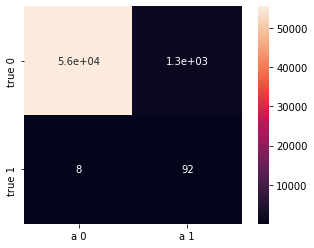

,true 0,true 1
a 0,55544,8
a 1,1318,92


In [ ]:
built_conf_matr(y_test, y_pred)

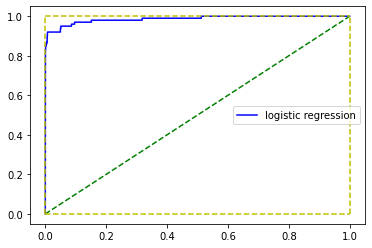

roc_auc after normalization: 0.9863186310717175


In [ ]:
fpr_, tpr_ = built_roc_auc(y_test, y_pred_proba)
print('roc_auc after normalization:',  auc(fpr_, tpr_))

In [ ]:
cross_val_score_my(grid.best_estimator_, X, y)

cross_val_score  auc: 0.980 +- 0.007 


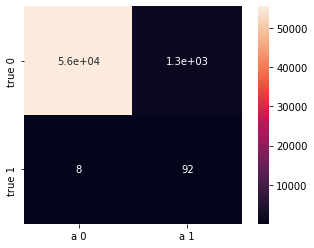

In [ ]:
cfm = built_conf_matr(y_test, y_pred)

In [ ]:
print((y_test == 1).sum(), (y_test == 0).sum())
cfm.sum(axis = 0)

100 56862


true 0    56862
true 1      100
dtype: int64

#### Мы тут небольшой фича-инжениринг сделали, добавили индикатор ночи( Меньше 10 часов). И индикатор 0-я транзакций для доля мошеннических транзакций велика, по сравнению с обычными. 

In [ ]:

X_new = df.drop(columns = ['t_s', 't_m', 't_d','Class'])
X_new['night'] = X_new['t_h'].apply(lambda h: int(h <= 10))
X_new['zero_amount'] = X_new['Amount'].apply(lambda a: int(a == 0)) 

numeric_cols = [col for col in X_new.columns if col[0] == 'V']
numeric_cols = numeric_cols + ['Amount'] + ['Time']

X_new = X_new.drop(columns = ['t_h'])
X_new.head(5), numeric_cols

(   Time        V1        V2        V3  ...       V28  Amount  night  zero_amount
 0   0.0 -1.359807 -0.072781  2.536347  ... -0.021053  149.62      1            0
 1   0.0  1.191857  0.266151  0.166480  ...  0.014724    2.69      1            0
 2   1.0 -1.358354 -1.340163  1.773209  ... -0.059752  378.66      1            0
 3   1.0 -0.966272 -0.185226  1.792993  ...  0.061458  123.50      1            0
 4   2.0 -1.158233  0.877737  1.548718  ...  0.215153   69.99      1            0
 
 [5 rows x 32 columns],
 ['V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V19',
  'V20',
  'V21',
  'V22',
  'V23',
  'V24',
  'V25',
  'V26',
  'V27',
  'V28',
  'Amount',
  'Time'])

Сделаем box-cox преобразование для сильно skew дата. 

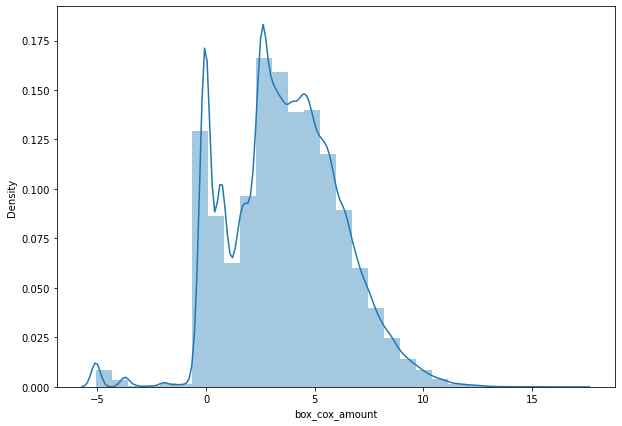

In [ ]:
from scipy.stats import boxcox

fig, ax = plt.subplots(figsize = (10, 7))

amount_positive = X_new.Amount.copy(deep = True)
idxs = np.where(X_new.Amount == 0)[0]
amount_positive[idxs] = 0.001

X_new['box_cox_amount'], _ = boxcox(amount_positive)
sns.distplot(a = X_new.box_cox_amount, bins = 30, hist = True, ax = ax)
X_new =  X_new.drop(columns = ['Amount'])

In [ ]:
X_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,night,zero_amount,box_cox_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1,0,6.401464
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1,0,1.037192
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1,0,7.957824
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1,0,6.096529
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1,0,5.225613


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin
class StandardScaler_my(BaseEstimator, TransformerMixin):

    def __init__(self, cols = None):
      super().__init__()
      self._cols = cols
      return None

    def fit(self, X, y = None):
      # X - should be a pandas
      self._mean = X.loc[:, self._cols if self._cols is not None else X.columns].mean(axis = 0)
      self._std = X.loc[:, self._cols if self._cols is not None else X.columns].std(axis = 0)
      return self

    def transform(self, X):
      return (X.loc[:, self._cols if self._cols is not None else X.columns] - self._mean)/self._std

      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2)
pipe = make_pipeline(
    StandardScaler_my(),
    LogisticRegression(class_weight = 'balanced')
)
pipe.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standardscaler_my', StandardScaler_my(cols=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
y_pred = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)

In [ ]:
# Категоризация часов, потому что индикатор ночи влияет 
# на частоту транзакций и он немного отличается от того, что для класса 1 и класса 0
# Тут ещё ввел индикатор того, что транзакция имела значение Amount 0. Доля таких транзакций для класса 1 больше, чем для класса 0

In [ ]:
cross_val_score_my(pipe, X_new, y, cv = 5, text = 'categorize_hours')

cross_val_score categorize_hours auc: 0.980 +- 0.006 


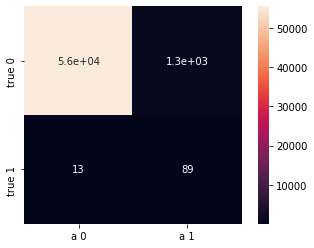

,true 0,true 1
a 0,55547,13
a 1,1313,89


In [ ]:
built_conf_matr(y_test, y_pred)

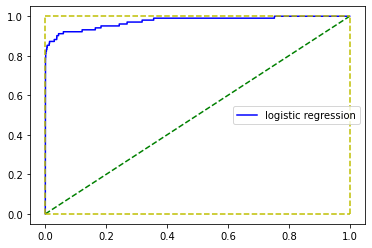

have some modification: 0.974


In [ ]:
fpr_, tpr_ = built_roc_auc(y_test, y_pred_prob);
print('have some modification: {:.3f}'.format(auc(fpr_, tpr_)))

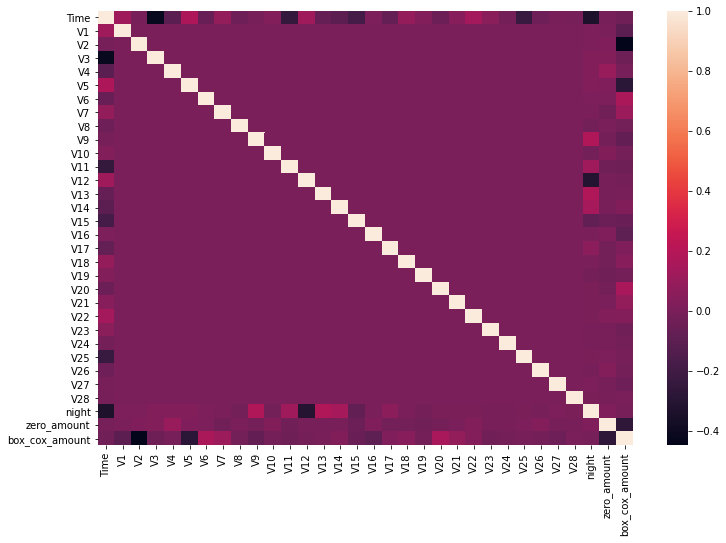

In [ ]:

fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(X_new.corr(), ax = ax)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2)

#### подбор по GridSearch.

In [ ]:
C = np.arange(0.1, 10, 10)
hyperparam_grid = {
                  "logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C": C, 
                   "logisticregression__fit_intercept": [True, False],
                   }

pipe = make_pipeline(
    StandardScaler_my(),
    LogisticRegression(class_weight = 'balanced'),
)
cv = StratifiedKFold(5, shuffle = True)
grid = GridSearchCV(pipe,param_grid= hyperparam_grid, cv = cv, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler_my',
                                        StandardScaler_my(cols=None)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                               

In [ ]:
grid.best_estimator_.get_params()

{'logisticregression': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                    fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'logisticregression__C': 0.1,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': False,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'memory': None,
 'standardscaler_my': St

In [ ]:
# С подбором некотрых параметров

Некоторый итог. На кросс-валидации.



In [ ]:
cross_val_score_my(grid.best_estimator_, X, y, cv = 5, scoring = 'roc_auc')

cross_val_score  auc: 0.984 +- 0.005 


In [ ]:
grid.best_estimator_.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler_my', StandardScaler_my(cols=None)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                    fit_intercept=False, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_prob = grid.best_estimator_.predict_proba(X_test)

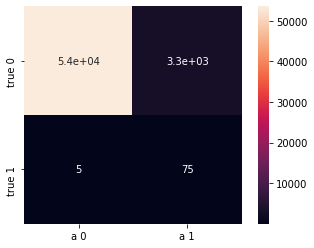

,true 0,true 1
a 0,53569,5
a 1,3313,75


In [ ]:
built_conf_matr(y_test, y_pred)

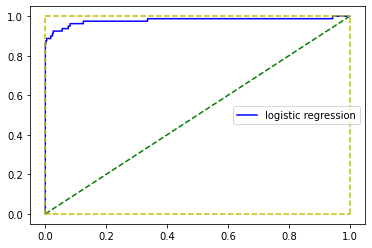

0.9787540434583877

In [ ]:
fpr_, tpr_ = built_roc_auc(y_test, y_pred_prob);
auc(fpr_, tpr_)

In [ ]:
from sklearn.metrics import SCORERS
keys = set(SCORERS.keys())
scorings = ['f1', 'recall', 'precision', 'roc_auc', 'accuracy']
for scor in scorings:
  if(scor not in keys):
    print(scor, ' not exsist!')


In [ ]:
# Рассмотрим для нашего алгоритма все метрики precision, recall, accuracy, f1, roc_auc
model_best = grid.best_estimator_
values_metric = {}
for idx, scor in enumerate(scorings):
  n_scores = cross_val_score_my(model_best, X_new, y, cv = 7, 
                                scoring = scor, text = scor + ' ', return_scores = True)
  values_metric[scor] = n_scores.mean()



cross_val_score f1  auc: 0.059 +- 0.005 
cross_val_score recall  auc: 0.931 +- 0.028 
cross_val_score precision  auc: 0.031 +- 0.002 
cross_val_score roc_auc  auc: 0.982 +- 0.006 
cross_val_score accuracy  auc: 0.948 +- 0.004 


In [ ]:
# Матрица ошибок confusion matrix

Мы постарались сделать так, чтобы класс мошеннических лучше различался. НАМ ВАЖНО ВЫЛАВЛИВАТЬ ИХ!

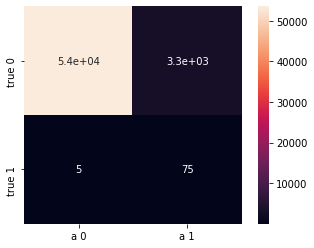

,true 0,true 1
a 0,53569,5
a 1,3313,75


In [ ]:
# надо по другому раскрасить 
built_conf_matr(y_test, y_pred)

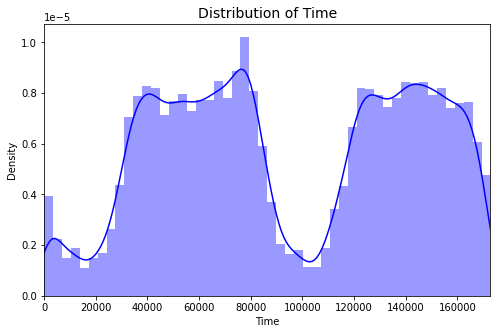

In [ ]:
fig, ax  = plt.subplots(figsize = (8, 5))
Time = df.Time
sns.distplot(a = Time, bins = 50, hist = True, color = 'b', ax = ax)
ax.set_title('Distribution of Time', fontsize = 14)
ax.set_xlim(left = Time.values.min(), right = Time.values.max())
plt.show()

### Поробуем сделать DownSampling до уровня отношения классов 50/50. Довольно опрометчиво удалять столько данных. Но попробуем!

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scale = StandardScaler()
rob_scale = RobustScaler()

df['scaled_Amount'] = rob_scale.fit_transform(df.Amount.values[:, None])
df['scaled_Time'] = rob_scale.fit_transform(df.Time.values[:, None])

df = df.drop(['Time', 'Amount'], axis = 1)

In [ ]:
# for insert first columns
scaled_Amount = df['scaled_Amount']
scaled_Time = df['scaled_Time']

df = df.drop(columns = ['scaled_Amount', 'scaled_Time'], axis = 1)
df.insert(0, 'scaled_Amount', scaled_Amount)
df.insert(1, 'scaled_Time', scaled_Time)


In [ ]:
df.head()

,scaled_Amount,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,t_d,t_h,t_m,t_s
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,0,0,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,0,0,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,0,0,1
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,0,0,1
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,0,0,2


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
df = df.sample(frac = 1) # shuffle random
df.head()

,scaled_Amount,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,t_d,t_h,t_m,t_s
166834,-0.296653,0.395247,-0.043924,0.784120,-2.177953,-2.164026,3.634861,2.735047,1.052504,0.611482,-0.551229,-0.455099,-0.147097,-0.116272,-0.470909,0.927224,0.243337,-0.739134,-0.483489,-0.502455,-0.259043,-0.001219,0.244370,0.796976,-0.211096,0.755243,-0.272899,0.109119,0.414498,0.262515,0,1,8,52,15
80514,-0.167819,-0.307452,1.297184,-0.551582,0.646926,-1.062745,-1.051244,-0.298708,-0.903773,0.147967,2.099393,-0.960419,-1.423779,-0.608760,-1.255642,0.163962,2.493076,0.417400,-0.790542,1.269639,0.506992,-0.151678,0.186049,0.618529,-0.223804,-0.637871,0.566435,-0.483958,0.091752,0.028439,0,0,16,15,22
63811,0.229721,-0.397267,-0.769268,-0.098799,1.454134,-1.437819,-0.653387,-0.657554,0.208390,-0.581698,-2.572966,1.893131,0.397709,-0.583830,1.316319,-0.674333,0.940855,-1.624659,1.187352,-1.037113,0.730144,-0.205170,-0.527144,-0.750525,-0.186008,0.385138,-0.527233,-0.520798,-0.750139,-0.755792,0,0,14,7,57
21388,-0.289387,-0.623327,-0.377589,1.079612,1.264757,0.011935,0.197176,-0.518399,0.617737,0.076917,-0.367920,-0.548519,-0.024360,-0.101300,-0.104651,-0.361154,1.167572,0.099152,0.298553,-0.563832,-0.447770,0.063415,-0.240028,-0.590847,0.011537,0.017534,-0.241337,0.102306,0.261677,0.094200,0,0,8,47,15
91098,10.172570,-0.251166,-3.101846,-3.801429,1.085071,-1.592506,-0.937389,0.926463,1.275678,0.440136,1.594326,-2.483126,-0.186595,0.377933,-1.482531,-0.220087,-0.962927,-0.645369,0.043020,0.730530,0.761879,1.861755,0.623524,0.340360,1.517725,-0.852347,0.987434,0.131608,-0.238667,0.121087,0,0,17,35,13


In [ ]:
df_fraud = df[df.Class == 1]
df_non_fraud = df[df.Class == 0].iloc[:len(df_fraud)]


In [ ]:
df_fraud.shape, df_non_fraud.shape

((492, 35), (492, 35))

In [ ]:
small_df = pd.concat([df_fraud, df_non_fraud])
# we can shuffle also our data after shuffle

In [ ]:
small_df_shuffled = small_df.sample(frac = 1, random_state = 42) # we can set our rs
small_df_shuffled

,scaled_Amount,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,t_d,t_h,t_m,t_s
153986,-0.098512,0.189687,1.980175,-0.478366,-0.192920,0.149892,-0.257576,0.826421,-1.127818,0.232001,2.374915,-0.251164,1.178705,-1.490726,2.402010,1.151760,-0.576052,1.005750,-0.435790,0.937806,0.007959,-0.116699,-0.107887,0.041129,0.253215,-0.135803,-0.527763,0.441116,-0.043332,-0.053801,0,1,4,0,38
151196,7.678055,0.120537,0.842025,-0.365518,-2.464063,4.820886,0.775505,-0.614785,1.368024,-0.526262,-0.121356,-0.357616,0.637767,-2.818882,2.360595,-1.108699,-1.449951,1.573740,2.202652,0.800471,-2.103583,0.944915,-0.110622,-1.257800,-0.324418,-0.420020,-0.219501,-0.268873,-0.144582,0.104464,1,1,2,22,32
2056,0.748271,-0.976292,-1.155913,0.180536,2.441583,1.832878,0.442081,2.590979,-0.182684,0.889331,0.369543,-0.447403,-0.912215,0.461599,-0.779121,-0.924797,-1.801081,-1.283382,1.193684,-2.553688,-2.314471,-0.458310,-0.074146,0.272516,0.073757,-0.960253,-0.726349,-0.168511,0.192803,0.113872,0,0,0,26,31
150697,1.047998,0.108413,-12.381048,8.213022,-16.962530,7.116091,-9.772826,-3.666836,-16.147363,2.078706,-4.250657,-16.746044,7.425801,-15.564838,-0.426338,-14.029538,-1.681889,-11.133761,-15.833589,-5.748533,2.271082,0.537795,0.167703,1.503413,-0.767755,0.371951,-1.415639,-0.517022,-0.434621,0.292721,1,1,2,5,20
153823,-0.275554,0.182462,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,-8.960922,-18.913243,4.971249,-12.686308,-1.071443,-7.383370,-2.992430,-8.582309,-13.806568,-6.000359,1.422632,3.834649,-8.228874,3.318178,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,1,1,3,50,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150661,0.319989,0.107626,-6.185857,7.102985,-13.030455,8.010823,-7.885237,-3.974550,-12.229608,4.971232,-4.248307,-12.965481,8.688308,-17.182918,0.069577,-14.116156,0.959032,-12.375334,-18.716765,-6.522015,3.517955,0.483930,2.502772,0.481691,0.480958,0.360319,-0.293354,-0.199193,-0.203917,0.398927,1,1,2,4,13
241445,-0.157898,0.779344,-3.818214,2.551338,-4.759158,1.636967,-1.167900,-1.678413,-3.144732,1.245106,-1.692541,-4.759931,3.642257,-4.165202,0.703070,-7.624316,-1.498012,-4.079992,-6.717177,-1.887550,1.356748,0.164453,0.837685,0.761712,-0.417694,-0.469712,-0.225934,0.586415,-0.348107,0.087777,1,1,17,57,9
6918,-0.136938,-0.889778,1.279036,0.537575,0.050885,1.207763,0.220163,-0.731886,0.322883,-0.367562,1.108796,-0.365924,0.207054,-2.199142,2.192374,1.781408,0.021220,0.011561,0.165235,0.070181,-0.303758,-0.128869,-0.202155,-0.280724,-0.157239,-0.165584,0.785452,-0.367942,-0.022122,0.007692,0,0,2,29,15
214662,1.376930,0.647035,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,-5.416037,4.497929,-5.019610,-1.019691,-7.914989,0.669648,-4.472014,-5.856998,-2.243178,-0.173814,0.589575,0.983481,0.899876,-0.285103,-1.929717,0.319869,0.170636,0.851798,0.372098,1,1,14,49,27


In [ ]:

idx = small_df_shuffled[small_df_shuffled.Class == 1].index
idx_non = small_df_shuffled[small_df_shuffled.Class == 0].index


In [ ]:
# check
print('part of 0 : {:.2f}, part of 1: {:.2f}'.format((small_df_shuffled.Class == 0).sum()/len(small_df_shuffled), 
                                                     (small_df_shuffled.Class == 1).sum()/len(small_df_shuffled)))

part of 0 : 0.50, part of 1: 0.50


Если построить данные для корреляций, при несбалансированном случае и сбалансированном, отличается сильно!!!


Text(0.5, 1.0, 'balanced case')

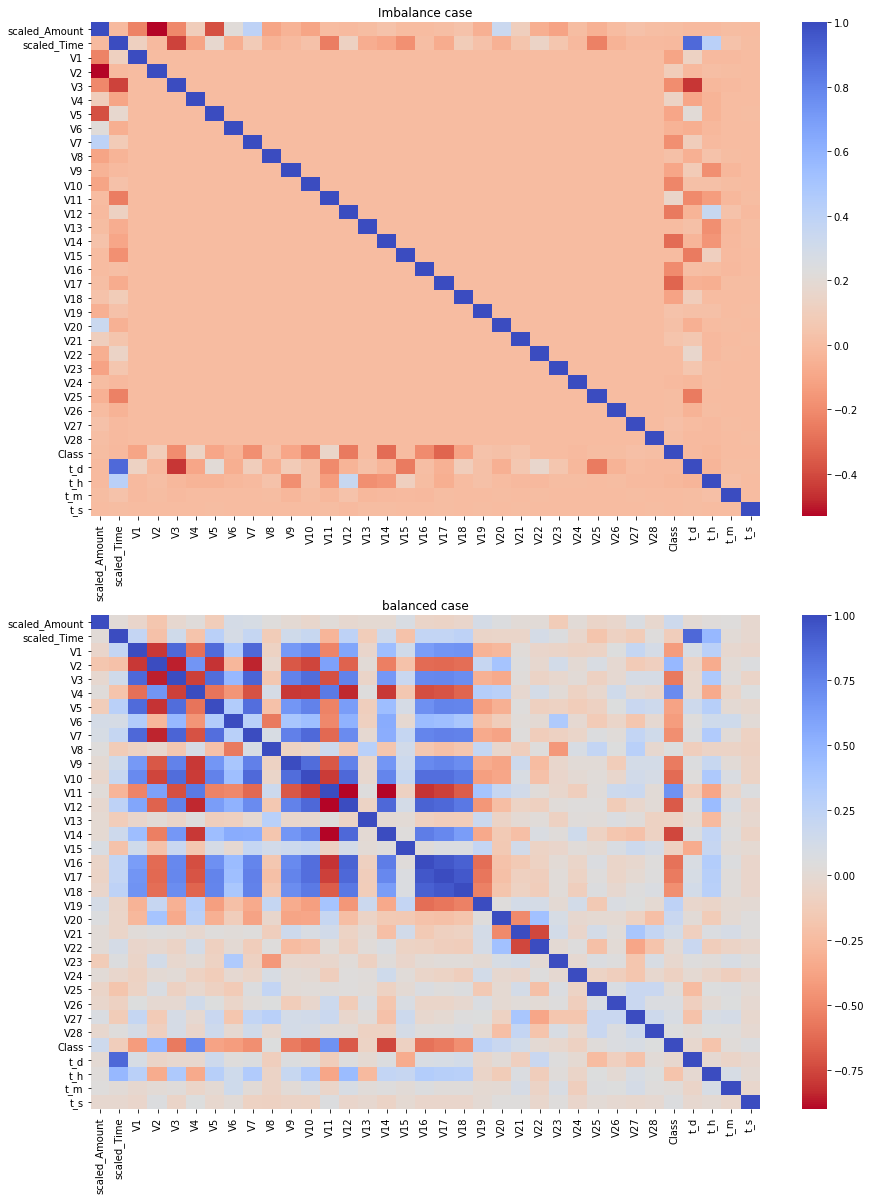

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (15, 20))
sns.heatmap(df.corr(), annot = False, ax = ax[0], cmap = 'coolwarm_r')
sns.heatmap(small_df_shuffled.corr(), annot = False, cmap = 'coolwarm_r', ax = ax[1])
ax[0].set_title('Imbalance case')
ax[1].set_title('balanced case')




In [ ]:
# positive correlations (на картинку посмотрели)
cols_pos_corr = ['V11', 'V4', 'V2', 'V19']
cols_neg_corr = ['V17', 'V14', 'V12', 'V10']

small_df_shuffled.head()

,scaled_Amount,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,t_d,t_h,t_m,t_s
153986,-0.098512,0.189687,1.980175,-0.478366,-0.192920,0.149892,-0.257576,0.826421,-1.127818,0.232001,2.374915,-0.251164,1.178705,-1.490726,2.402010,1.151760,-0.576052,1.005750,-0.435790,0.937806,0.007959,-0.116699,-0.107887,0.041129,0.253215,-0.135803,-0.527763,0.441116,-0.043332,-0.053801,0,1,4,0,38
151196,7.678055,0.120537,0.842025,-0.365518,-2.464063,4.820886,0.775505,-0.614785,1.368024,-0.526262,-0.121356,-0.357616,0.637767,-2.818882,2.360595,-1.108699,-1.449951,1.573740,2.202652,0.800471,-2.103583,0.944915,-0.110622,-1.257800,-0.324418,-0.420020,-0.219501,-0.268873,-0.144582,0.104464,1,1,2,22,32
2056,0.748271,-0.976292,-1.155913,0.180536,2.441583,1.832878,0.442081,2.590979,-0.182684,0.889331,0.369543,-0.447403,-0.912215,0.461599,-0.779121,-0.924797,-1.801081,-1.283382,1.193684,-2.553688,-2.314471,-0.458310,-0.074146,0.272516,0.073757,-0.960253,-0.726349,-0.168511,0.192803,0.113872,0,0,0,26,31
150697,1.047998,0.108413,-12.381048,8.213022,-16.962530,7.116091,-9.772826,-3.666836,-16.147363,2.078706,-4.250657,-16.746044,7.425801,-15.564838,-0.426338,-14.029538,-1.681889,-11.133761,-15.833589,-5.748533,2.271082,0.537795,0.167703,1.503413,-0.767755,0.371951,-1.415639,-0.517022,-0.434621,0.292721,1,1,2,5,20
153823,-0.275554,0.182462,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,-8.960922,-18.913243,4.971249,-12.686308,-1.071443,-7.383370,-2.992430,-8.582309,-13.806568,-6.000359,1.422632,3.834649,-8.228874,3.318178,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,1,1,3,50,23


Построим матрицу корреляции и между признаками.

In [ ]:
corr_matr = small_df_shuffled.corr()
corr_matr = corr_matr.unstack().sort_values(ascending = False).reset_index()
corr_matr = corr_matr.drop(index = corr_matr.iloc[1::2].index)
corr_matr.rename(columns = {'level_0' : 'f_1', 'level_1': 'f_2', 0: 'corr'}, inplace = True)
corr_matr.drop(index = corr_matr[corr_matr['corr'] == 1].index, inplace = True)
corr_matr

,f_1,f_2,corr
36,V17,V16,0.951062
38,V18,V17,0.943056
40,V16,V18,0.907465
42,V16,V12,0.901660
44,V3,V7,0.891079
...,...,...,...
1216,V12,V4,-0.839310
1218,V7,V2,-0.845231
1220,V2,V3,-0.858726
1222,V14,V11,-0.898779


In [ ]:
class_mask = ((corr_matr.f_1 == 'Class') | (corr_matr.f_2 == 'Class'))
corr_class = corr_matr[class_mask]
positive_high_corr = corr_class[corr_class['corr'] > 0.2]
negative_high_corr = corr_class[corr_class['corr'] < -0.6]

In [ ]:
positive_high_corr

,f_1,f_2,corr
118,Class,V4,0.711718
126,Class,V11,0.685438
160,V2,Class,0.465616
226,V19,Class,0.249086


In [ ]:
negative_high_corr

,f_1,f_2,corr
1166,Class,V10,-0.624105
1178,V12,Class,-0.684439
1194,V14,Class,-0.749225


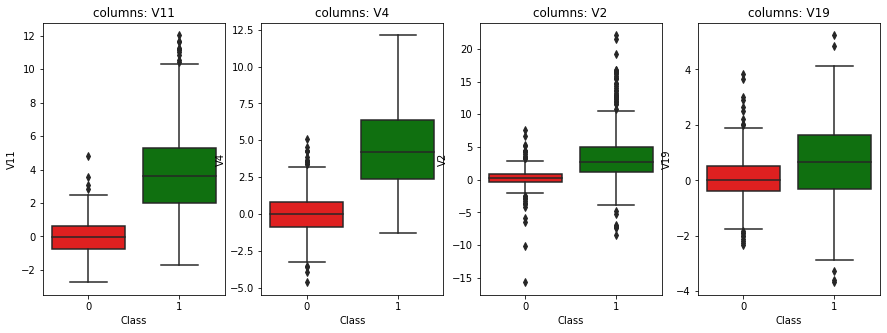

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for idx in range(4):
  sns.boxplot(x = 'Class', y = cols_pos_corr[idx],
              data = small_df_shuffled, palette = ['r', 'g'], ax = ax[idx])
  
  ax[idx].set_title('columns: {}'.format(cols_pos_corr[idx]))


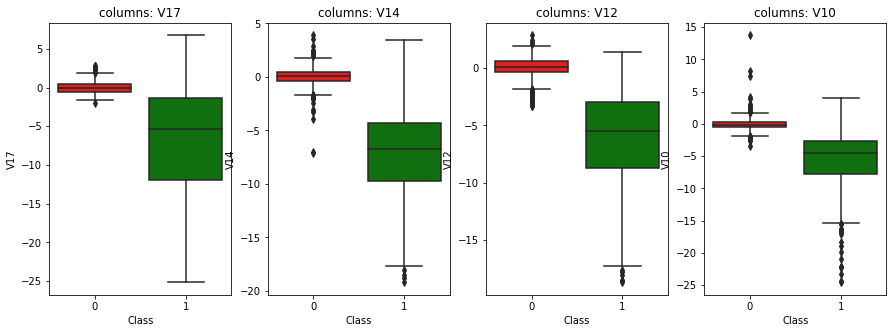

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for idx in range(4):
  sns.boxplot(x = 'Class', y = cols_neg_corr[idx],
              data = small_df_shuffled, palette = ['r', 'g'], ax = ax[idx])
  
  ax[idx].set_title('columns: {}'.format(cols_neg_corr[idx]))


Частая практика в том, чтобы убирать из заметно скоррелированных признаков outliers
Можно по разному определять выбросы, один из способов это просто интерквантильный метод
Но обычно стоит выбрасывать экстремально большие выбросы, а не средние выбросы, так как это может (особенно на маленьких данных) повлиять сильно
можно варьировать значение тресхолда и смотреть, как это влияет на точность (мб другая метрика) предсказаний.

Построим признаки вышенайденные!

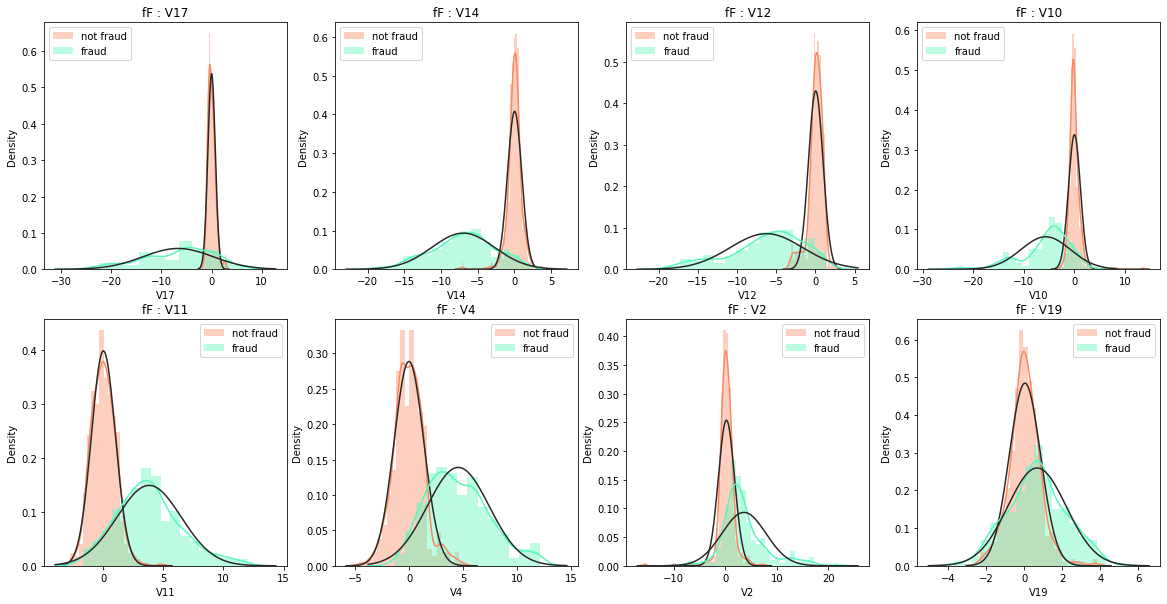

In [ ]:
from scipy.stats import norm
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
for idx in range(4):
  sns.distplot(a = small_df_shuffled[small_df_shuffled.Class == 0][cols_neg_corr[idx]],
                  fit = norm, ax = ax[0][idx], label = 'not fraud', color = '#FB8861')
  sns.distplot(a = small_df_shuffled[small_df_shuffled.Class == 1][cols_neg_corr[idx]],
                  fit = norm, ax = ax[0][idx], label = 'fraud', color = '#56F9BB')
  
  sns.distplot(a = small_df_shuffled[small_df_shuffled.Class == 0][cols_pos_corr[idx]],
                  fit = norm, ax = ax[1][idx], label = 'not fraud', color = '#FB8861')
  sns.distplot(a = small_df_shuffled[small_df_shuffled.Class == 1][cols_pos_corr[idx]],
                  fit = norm, ax = ax[1][idx], label = 'fraud', color = '#56F9BB')
  
  ax[0][idx].legend()
  ax[0][idx].set_title('fF : {}'.format(cols_neg_corr[idx]))
  
  ax[1][idx].legend()
  ax[1][idx].set_title('fF : {}'.format(cols_pos_corr[idx]))

    


Видно, что некоторые немного отличаются от нормального распределения, попробуем выделить выбросы (*1.5)
А также выбрасывать выбросы стоит только по каждому классу отдельно, так как видно, что распределения отличаются тут (мошеннические более сконцентрированны в 0) меньше дисперсия у них.

In [ ]:
def remove_outliers(data, col, Class = 0, k = 1.5):
  assert(isinstance(col, str))
  v = data[data.Class == Class][col].values
  p1, p3 = np.percentile(v, 25), np.percentile(v, 75) 
  irq = (p3-p1)
  val_lower = p1 - irq * k 
  val_higher = p3 + irq * k 
  outliers = [x for x in v if x < val_lower or x > val_higher]
  print('lower : {:.2f}, upper: {:.2f}'.format(val_lower, val_higher))
  print('outliers in {} number: {}'.format(col, len(outliers)))
  m = data.Class == Class
  new_data = data.drop(index = data[(data[col] > val_higher) | (data[col] < val_lower)].index) 
  return new_data


small_df_c = small_df_shuffled.copy(deep = True)
for idx, col in enumerate(cols_neg_corr + cols_pos_corr):
  small_df_c = remove_outliers(small_df_c, col, Class = 1)

small_df_c.shape

lower : -27.85, upper: 14.56
outliers in V17 number: 0
lower : -17.81, upper: 3.83
outliers in V14 number: 4
lower : -17.34, upper: 5.78
outliers in V12 number: 4
lower : -14.90, upper: 4.92
outliers in V10 number: 27
lower : -2.62, upper: 9.45
outliers in V11 number: 13
lower : -3.28, upper: 11.34
outliers in V4 number: 2
lower : -3.09, upper: 8.13
outliers in V2 number: 44
lower : -3.90, upper: 5.09
outliers in V19 number: 1


(871, 35)

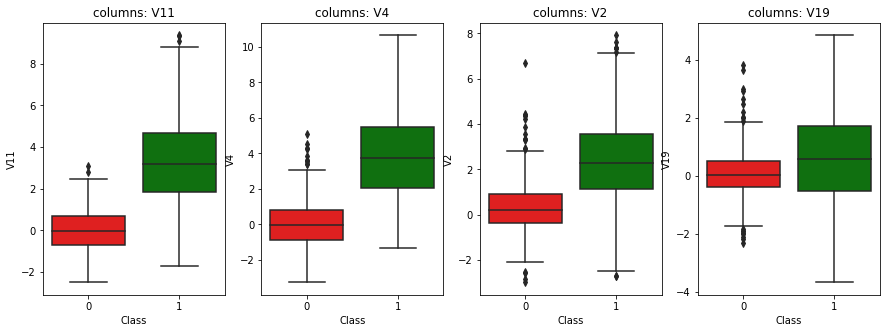

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for idx in range(4):
  sns.boxplot(x = 'Class', y = cols_pos_corr[idx],
              data = small_df_c, palette = ['r', 'g'], ax = ax[idx])
  
  ax[idx].set_title('columns: {}'.format(cols_pos_corr[idx]))

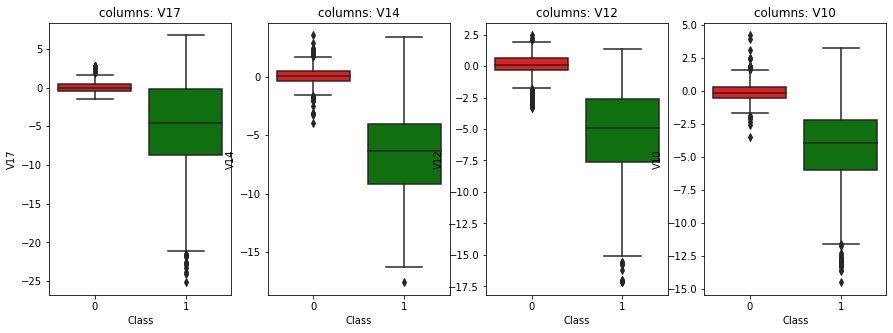

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for idx in range(4):
  sns.boxplot(x = 'Class', y = cols_neg_corr[idx],
              data = small_df_c, palette = ['r', 'g'], ax = ax[idx])
  
  ax[idx].set_title('columns: {}'.format(cols_neg_corr[idx]))


In [ ]:
# Обучим модель с учетом того, как мы убрали выбросы для маленького датасета методом Downsampling

In [ ]:
X = small_df_c.drop(columns = ['Class'])
y = small_df_c['Class']


Делать разделение данных уже после произведения downsampling является ли корректным? 
По идее, это можно делать только на train  после разделения выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
# преобразуем в numpy
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values


Построим простые решения на Knearest, и logisticregression.

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
}
scores = []
for key, classifier in classifiers.items():
  classifier.fit(X_train, y_train)
  n_scores = cross_val_score(classifier, X_train, y_train, cv = 5, scoring = 'roc_auc')
  print('Classifier: {} train score: {:.3f} %'.format(classifier.__class__.__name__, 
                                                    n_scores.mean() * 100.))
  


Classifier: LogisticRegression train score: 97.152 %
Classifier: KNeighborsClassifier train score: 90.110 %


# 2 - Небинарная классификация на вашем датасете (суммарно 6 баллов)

### (2 балла) Выберите какой-нибудь интересный вам датасет, скачайте его и считайте данные

Творческое задание - найти в интернете (или собрать свой даже) датасет, сохранить его в файл, и загрузить сюда.

Требования:

- он должен быть немаленький (хотя бы 500 объектов, лучше больше)
- он должен быть интересный
- таргет должен быть небинарным классом

Минус балл, если ваш датасет с кем-нибудь повторится.

## Fashion MNIST. Classification.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
 

In [ ]:
! unzip '/content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz' -d data_fashion

Archive:  /content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz or
        /content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz.zip, and cannot find /content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz.ZIP, period.


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Импортирую данный теже самые, что и из ссылки на соревнование.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


####  Мы скачали наши данные для дальнейшей работы! Далее мы попробуем произвести логитическую регрессию, многоклассовую с помощью инструментов Pytorch, так как будет удобнее работать именно с ним. Сравним некоторые типы метрик (для оценки многоклассовой классификации)!

In [ ]:
print('nums of train data {}\nsize if images: {}'.format(train_images.shape[0], 
                                                          train_images.shape[1:]))

print('---------------------------------------')
print('nums of test n data {}\nsize if images: {}'.format(test_images.shape[0], 
                                                          test_images.shape[1:]))

nums of train data 60000
size if images: (28, 28)
---------------------------------------
nums of test n data 10000
size if images: (28, 28)


Данные специально для нас предоставили уже сбалансированные.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'train labels')

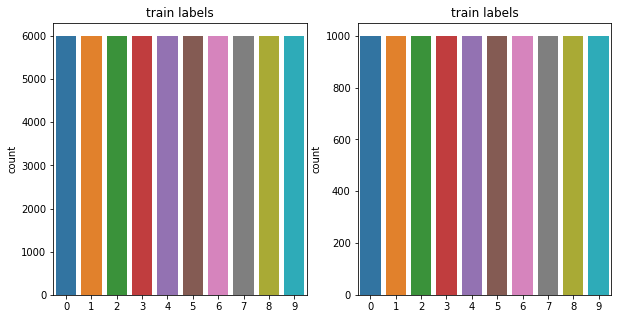

In [ ]:
# Рассмотрим доли предложенных нам объектов:
import seaborn as sns
import pandas as pd

unique, counts = np.unique(train_labels, return_counts = True)
unique, counts
train_labels_series = pd.Series(train_labels)
test_labels_series = pd.Series(test_labels)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.countplot(train_labels_series, ax = ax[0])
sns.countplot(test_labels_series, ax = ax[1])

ax[0].set_title('train labels')
ax[1].set_title('train labels')



In [ ]:
# Видно, что четко сбалансированны данные нам не надо думать о балансировке

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

Ниже я пытался написать свой генератор батчей. Но это не очень удобно, наиболее просто это сделать с помощью DataLoader.

In [ ]:
val_size = 0.3
train_images, val_images, train_labels, val_labels =  train_test_split(train_images, 
                                                                       train_labels,
                                                                       test_size = val_size, 
                                                                       random_state = 42)

def loader_generator(X, y, batch_size = 100, shuffle = True):
  """
  This should returned tensors torch.float32
  """
  assert(X.shape[0] == y.shape[0])
  indeces = np.arange(X.shape[0])
  if shuffle:
    np.random.shuffle(indeces)  
    #assert(indeces[0] != 0)
  for idx in range(0, len(indeces), batch_size):
    X_torch = torch.Tensor(X[indeces[idx: idx + batch_size]])
    y_torch = torch.Tensor(y[indeces[idx: idx + batch_size]])
    yield X_torch, y_torch


metrics_names = ['accuracy', 'precision', 'recall', 'f1']


### Перегруженный класс для формирования объекта Dataset

In [ ]:
class Datasetfashion(Dataset):

  def __init__(self, images, labels, 
               transforms = transforms.Compose([transforms.ToTensor()])):
    
    super().__init__()
    self._images = images
    self._labels = labels
    self._transform = transforms

  def __len__(self):
    return len(self._images)

  def __getitem__(self, idx):
    try:
      img = self._images[idx]
      label = self._labels[idx]
    except:
      idx = np.random.randint(0, self.__len__(), size = 1)
      img = self._images[idx]
      label = self._labels[idx]

    img_transf = self._transform(img)
    return img_transf, label


data_ = Datasetfashion(train_images, train_labels)
loader_example = DataLoader(data_, batch_size = 10, shuffle = True, )
for x, y in loader_example:
  print(x.shape, y.shape)
  break

torch.Size([10, 1, 28, 28]) torch.Size([10])


### Сама модель.

Тут я решил просто сделать один слой, где признаками являются множество пикселей 28*28 = 784. И архиетктура представляет собой multiclassregression с минимизацией cross_entropy_loss. 

In [ ]:
class FMnistFashion(nn.Module):

  def __init__(self, in_s, out_s):
    super().__init__()
    self._layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_s, out_s),
    )
    #self._logsoftmax = nn.LogSoftmax(dim = 1)

  def forward(self, input):
    out = self._layers(input)
    #out  = self._logsoftmax(out)
    return out

m = FMnistFashion(28 * 28, 10)
for x, y, in loader_generator(train_images, train_labels):
  out = m(x)
  print(out.shape)
  break

torch.Size([100, 10])


#### Обучение


Данная функция проводит обучение с подсчётом функции потерь, а также рассчитывает на каждом шаге metric качества, такие как f1, accuracy, recall, precision. А также на валидации, для отслеживания. Ниже будут приведены графики соответствующих метрик для валидации для в зависимости от эпох. Для удобства есть возможность менять параметр average для 'micro'/'macro' стратегии расчёта вышеупомянутых метрик.

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
def accuracy_new(outputs, labels):
  pred = outputs.argmax(dim = 1)
  return (pred == labels).sum()/labels.shape[0]


def fit_new(epochs, lr, model, 
            train_images, val_images,
            train_labels, val_labels,
            opt_func = torch.optim.SGD,
            batch_size = 50,
            metric: str = 'accuracy',
            mode = 'macro',
            return_train_scores = False):
  
  stack_metrics = [accuracy_score, precision_score, recall_score, f1_score]
  dict_metrics_stack = {name: metric for name, metric in zip(metrics_names, stack_metrics)}
  criterion = nn.CrossEntropyLoss()
  
  losses_batch = []
  metric_scores_batch = []
  acc_arr = []
  val_scores = []

  optimizer = torch.optim.SGD(model.parameters(), lr = lr)
  data_train = Datasetfashion(train_images, train_labels)
  data_val = Datasetfashion(val_images, val_labels)
  train_loader = DataLoader(data_train, batch_size, shuffle = True)
  val_loader = DataLoader(data_val, batch_size, shuffle = True)

  for epoch in tqdm(range(epochs)):
    
    losses_by_batch = []
    metrics_by_batch = []

    for x, y in train_loader:

      optimizer.zero_grad()
      out = model(x)
      loss = criterion(out, y.long())
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        losses_by_batch.append(loss.item())
        dict_scores = {}
        for m_name, m in zip(metrics_names, stack_metrics):
          out_pred = out.argmax(dim = 1)
          if(m_name.find('acc') == 0):
            score = m(y.detach().numpy(), 
                      out_pred.detach().numpy(), 
                      )
            
          else:
            score = m(y.detach().numpy(), 
                      out_pred.detach().numpy(), 
                      average = mode)
            
          dict_scores[m_name] = score
        
        metrics_by_batch.append(dict_scores) 

    # calculate mean of batch
    mean_scores_by_batch = np.zeros((len(metrics_names)))
    for idx in range(batch_size):
      for jdx, name_metric in enumerate(metrics_names, 0):
        mean_scores_by_batch[jdx] += metrics_by_batch[idx][name_metric]

    mean_scores_by_batch = mean_scores_by_batch/batch_size
    metric_scores_batch.append({name: score for name, score in zip(metrics_names, mean_scores_by_batch)})

    # acc on validation set                                                          
    VAL_SCORE = 0
    times = 0
    for i, batch in enumerate(val_loader, 1):
      times += 1
      x, y = batch
      out = model(x)
      out = out.argmax(dim = 1)
      if(metric.find('acc') == 0): # for accuracy we don't need use average sklearn
        VAL_SCORE += dict_metrics_stack[metric](out.detach().numpy(), y.detach().numpy())
      else:
        VAL_SCORE += dict_metrics_stack[metric](out.detach().numpy(), 
                                                y.detach().numpy(),
                                                average = mode,
                                                )

    #print('-'*50)
    #print('\n {} on validation: {:.4f}'.format(metric[0].upper() + metric[1:], VAL_SCORE/times))
    val_scores.append(VAL_SCORE/times)

  if(return_train_scores):
    return [losses_batch, val_scores, metric_scores_batch]
  else:
    return [losses_batch, val_scores]
    
        


epochs = 30
lr = 0.01
      
model_new = FMnistFashion(in_s = 28*28, out_s = 10)
losses_history, metrics_history = fit_new(epochs,
                                          lr, 
                                          model_new,
                                          train_images, 
                                          val_images, 
                                          train_labels,
                                          val_labels,
                                          batch_size = 50,
                                          metric = 'f1',
                                          mode = 'micro')
 

100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


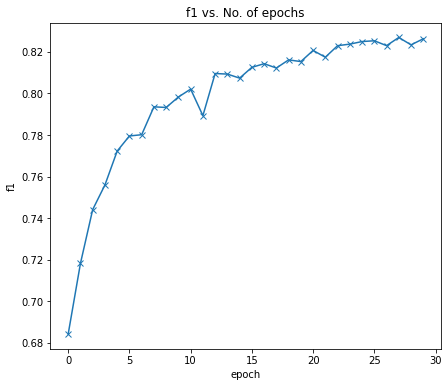

In [ ]:
name_metric = 'f1'
fig, ax = plt.subplots(figsize = (7, 6))
ax.plot(metrics_history, '-x')
ax.set_xlabel('epoch')
ax.set_ylabel('{}'.format(name_metric))
ax.set_title('{} vs. No. of epochs'.format(name_metric));

In [ ]:
model_new = FMnistFashion(in_s = 28*28, out_s = 10)
losses_history, metrics_history = fit_new(epochs,
                                          lr, 
                                          model_new,
                                          train_images, 
                                          val_images, 
                                          train_labels,
                                          val_labels,
                                          batch_size = 50,
                                          metric = 'accuracy',
                                          mode = 'micro')

100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


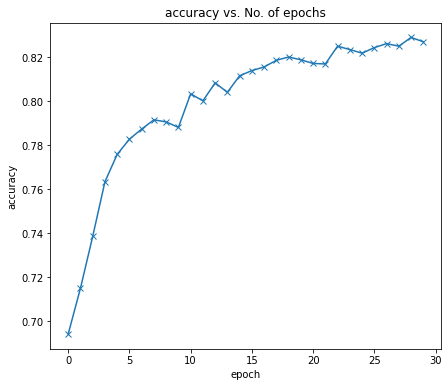

In [ ]:
name_metric = 'accuracy'
fig, ax = plt.subplots(figsize = (7, 6))
ax.plot(metrics_history, '-x')
ax.set_xlabel('epoch')
ax.set_ylabel('{}'.format(name_metric))
ax.set_title('{} vs. No. of epochs'.format(name_metric));

In [ ]:
model_new = FMnistFashion(in_s = 28*28, out_s = 10)
losses_history, metrics_history = fit_new(epochs,
                                          lr, 
                                          model_new,
                                          train_images, 
                                          val_images, 
                                          train_labels,
                                          val_labels,
                                          batch_size = 50,
                                          metric = 'precision',
                                          mode = 'micro')

100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


In [ ]:
model_new = FMnistFashion(in_s = 28*28, out_s = 10)
losses_history, metrics_history = fit_new(epochs,
                                          lr, 
                                          model_new,
                                          train_images, 
                                          val_images, 
                                          train_labels,
                                          val_labels,
                                          batch_size = 50,
                                          metric = 'recall',
                                          mode = 'micro')

100%|██████████| 30/30 [00:21<00:00,  1.36it/s]


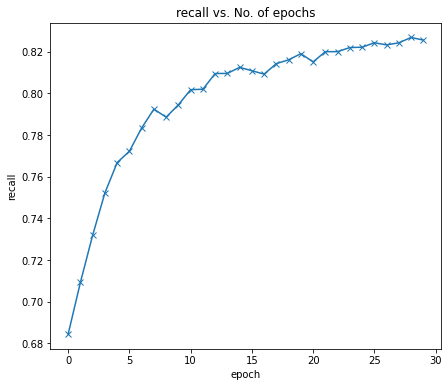

In [ ]:
name_metric = 'recall'
fig, ax = plt.subplots(figsize = (7, 6))
ax.plot(metrics_history, '-x')
ax.set_xlabel('epoch')
ax.set_ylabel('{}'.format(name_metric))
ax.set_title('{} vs. No. of epochs'.format(name_metric));

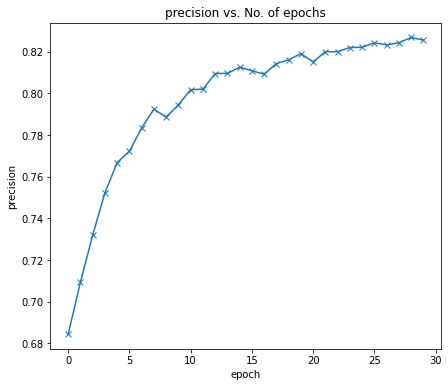

In [ ]:
name_metric = 'precision'
fig, ax = plt.subplots(figsize = (7, 6))
ax.plot(metrics_history, '-x')
ax.set_xlabel('epoch')
ax.set_ylabel('{}'.format(name_metric))
ax.set_title('{} vs. No. of epochs'.format(name_metric));